In [368]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from itertools import cycle
import shap

/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Datasets

In [293]:
data = pd.read_csv('dataset/All_Flows.csv')

In [294]:
data['label'].value_counts()

benign                     783574
port_scan                  160003
infiltration_dropbox_p2     63413
ddos                        45480
dos_hulk                    14108
dos_goldeneye                7574
dos_slowhttptest             4217
ftp_patator                  3993
dos_slowloris                3895
ssh_patator                  2979
webattack_bruteforce         1365
botnet                       1226
webattack_xss                 679
webattack_sqli                 12
infiltration_meta               4
heartbleed                      1
infiltration_cooldisk           1
infiltration_dropbox_p1         1
Name: label, dtype: int64

In [295]:
# Remove 'webattack_sqli', 'infiltration_meta', 'infiltration_dropbox_p1', 'heartbleed', 'infiltration_cooldisk
data = data[~data['label'].isin(['webattack_sqli', 'infiltration_meta', 'infiltration_dropbox_p1', 'heartbleed', 'infiltration_cooldisk'])]

In [296]:
df = data.copy()

In [297]:
df['label'].value_counts()

benign                     783574
port_scan                  160003
infiltration_dropbox_p2     63413
ddos                        45480
dos_hulk                    14108
dos_goldeneye                7574
dos_slowhttptest             4217
ftp_patator                  3993
dos_slowloris                3895
ssh_patator                  2979
webattack_bruteforce         1365
botnet                       1226
webattack_xss                 679
Name: label, dtype: int64

- Grouping similar attacks

In [298]:
# No longer needed

def group_label(label: str):
    if 'infiltration' in label:
        return 'infiltration'
    elif 'webattack' in label:
        return 'web attack'
    else:
        return label


# Data Exploration

In [299]:
# df = pd.concat([df_benign, df_botnet, df_portscan, df_ddos], axis=0)
# Remove Empty FLOW IDS
mask = ~df[['sport', 'src_ip', 'dst_port', 'dst_ip']].isnull().any(axis=1)

# Apply the mask to filter rows
df = df[mask]

- Flow id needs to be unique? => Not necessarily, same machine can be used in different attacks

In [300]:
# Create Flow ID Column
df['sport'] = df['sport'].astype(int).astype(str)
df['dst_port'] = df['dst_port'].astype(int).astype(str)
df['flow_id'] = df['src_ip'] + '-' + df['dst_ip'] + '-' + df['sport'] + '-' + df['dst_port']

In [301]:
# Count numple of flow ids duplicates
df['count_flow_id'] = df.groupby(['flow_id', 'label']).transform('count')['sport']

Checking if all the duplicates are from benign traffic or not

In [302]:
tmp = df[['flow_id', 'count_flow_id','label']].drop_duplicates().sort_values(by='count_flow_id', ascending=False)[['count_flow_id', 'label']]
tmp[tmp['count_flow_id'] > 1].value_counts()

count_flow_id  label 
2              benign    54496
3              benign    25121
4              benign    12090
5              benign     4160
6              benign     1111
14             benign      714
13             benign      698
15             benign      421
12             benign      407
7              benign      233
11             benign      138
16             benign      111
10             benign       35
17             benign       27
8              benign       26
9              benign       15
dtype: int64

- `flow_duration`

In [303]:
data['flow_duration'].describe()

count    1.092506e+06
mean     5.148961e+02
std      2.608950e+03
min      0.000000e+00
25%      1.560000e-04
50%      8.968800e-02
75%      1.110656e+01
max      2.904384e+04
Name: flow_duration, dtype: float64

In [304]:
data_benign = data[data['label'] == 'benign'].copy()

In [305]:
# # Calculate the 10th and 90th percentile values => For easy visualization
# q10 = data_benign['flow_duration'].quantile(0.10)
# q90 = data_benign['flow_duration'].quantile(0.90)

# filtered_df = data_benign[(data_benign['flow_duration'] >= q10) & (df['flow_duration'] <= q90)].copy()

In [306]:
# sns.boxplot(x='label', y='flow_duration', data=data_benign, showfliers=False, showmeans=False);

Analyzing flow duration distribution across all attacks

In [307]:
data['flow_duration_log'] = np.log10(data['flow_duration']+1)

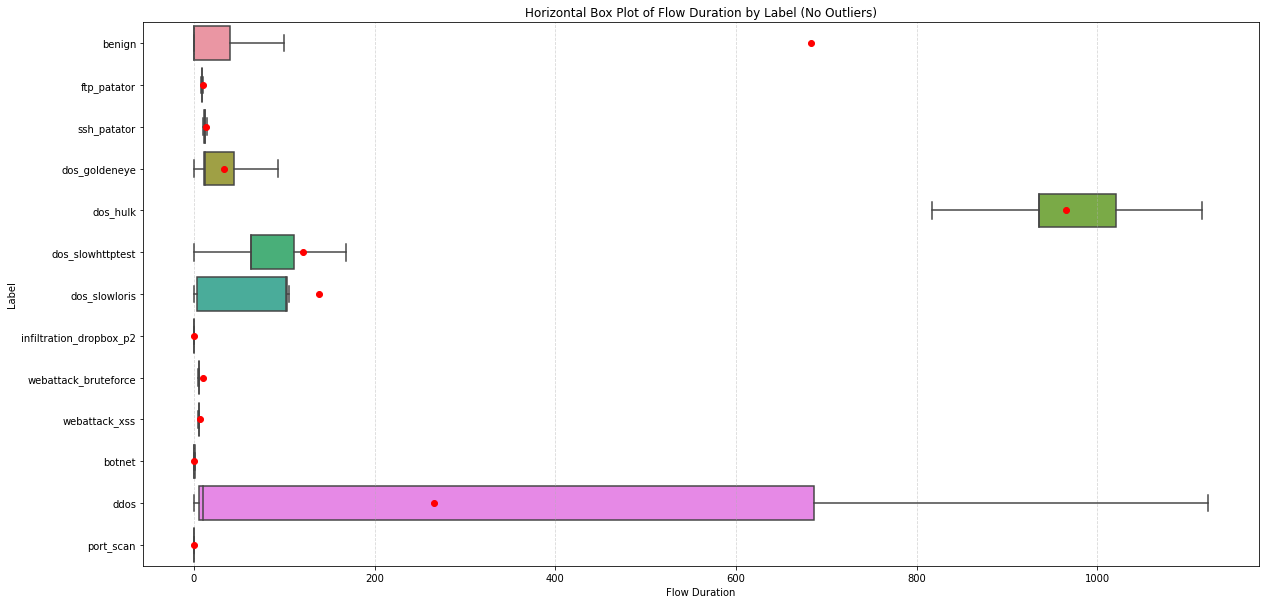

In [308]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='flow_duration', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by Label (No Outliers)')

plt.show()

Analyzing flow duration distribution across attacks with small flow duration

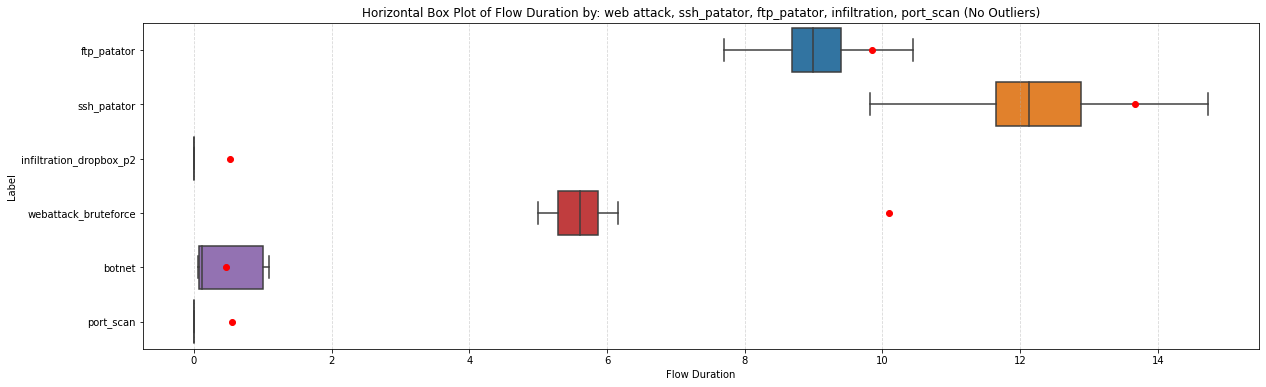

In [309]:
plt.figure(figsize=(20, 6))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='flow_duration', data=data[data['label'].isin(['webattack_bruteforce', 'ssh_patator', 'ftp_patator', 'infiltration_dropbox_p2',
                                                                        'port_scan', 'botnet'])],
            showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by: web attack, ssh_patator, ftp_patator, infiltration, port_scan (No Outliers)')

plt.show()

Log-Based

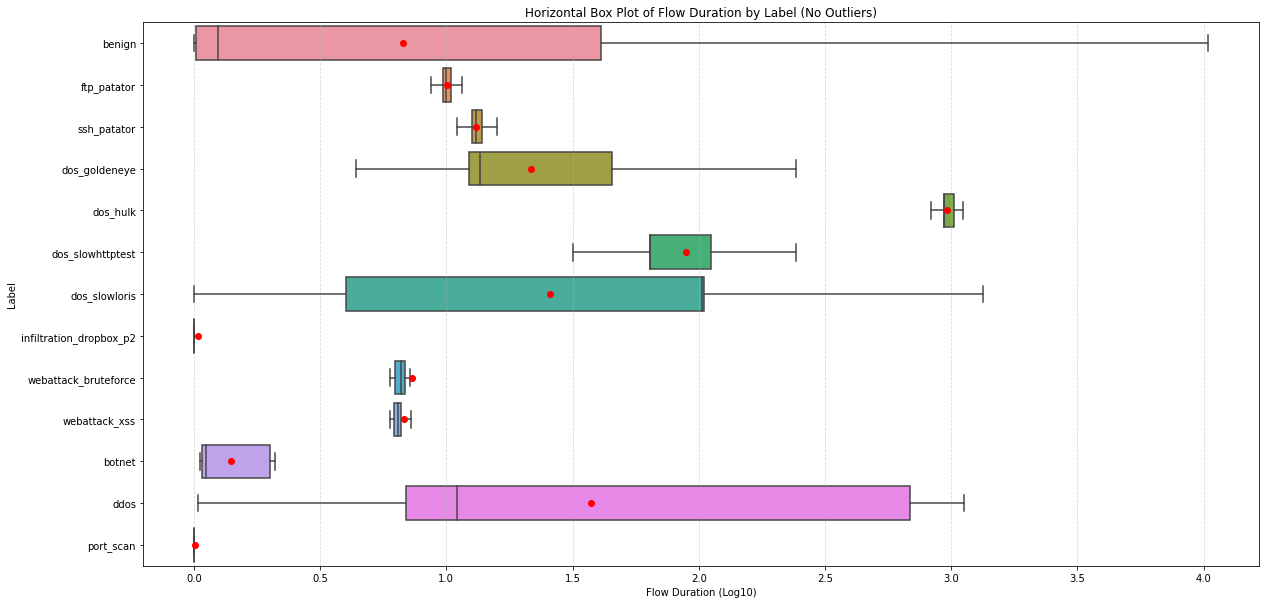

In [310]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='flow_duration_log', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Flow Duration (Log10)')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Flow Duration by Label (No Outliers)')

plt.show()

Perform T-tests for all Pairs of Labels

In [311]:
labels = data['label'].unique()

In [312]:
grouped = data.groupby('label')['flow_duration']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [313]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [314]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
18,ftp_patator,webattack_bruteforce,-0.198018,0.843039
28,ssh_patator,webattack_bruteforce,1.634120,0.102306
29,ssh_patator,webattack_xss,2.772891,0.005584
50,dos_slowhttptest,dos_slowloris,-3.367043,0.000763
65,infiltration_dropbox_p2,botnet,0.084962,0.932292
67,infiltration_dropbox_p2,port_scan,-0.362392,0.717059
68,webattack_bruteforce,webattack_xss,1.047477,0.295003
76,botnet,port_scan,-0.145058,0.884665


=> **Conclusion**: The statistical analysis using a t-test indicates that there is a significant difference in the distribution of flow durations between different attacks. This finding suggests that flow duration can serve as a meaningful indicator or predictor of attack events.

In the above table we can observe some exceptions: (dos_slowhttptest, dos_slowloris), (ssh_patator, web attack).

Both infiltration_dropbox_p2 and port_scan are not statistically different from each other, which is expected as infiltration_dropbox_p2 is essentially a port scan attack.

`total_packets`

In [315]:
data['total_packets'] = data['total_fwd_packets'] + data['total_bwd_packets']
data['total_packets_log'] = np.log10(data['total_packets']+1)

In [316]:
data['total_packets'].describe()

count    1.092506e+06
mean     3.795254e+01
std      5.489396e+03
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      1.800000e+01
max      2.458132e+06
Name: total_packets, dtype: float64

Analyzing total_packets distribution. Removing Heartbleed from analyzsis (only one sample)

In [317]:
list(set(data['label']))

['dos_hulk',
 'dos_slowhttptest',
 'dos_slowloris',
 'botnet',
 'ddos',
 'webattack_bruteforce',
 'benign',
 'ftp_patator',
 'port_scan',
 'infiltration_dropbox_p2',
 'dos_goldeneye',
 'webattack_xss',
 'ssh_patator']

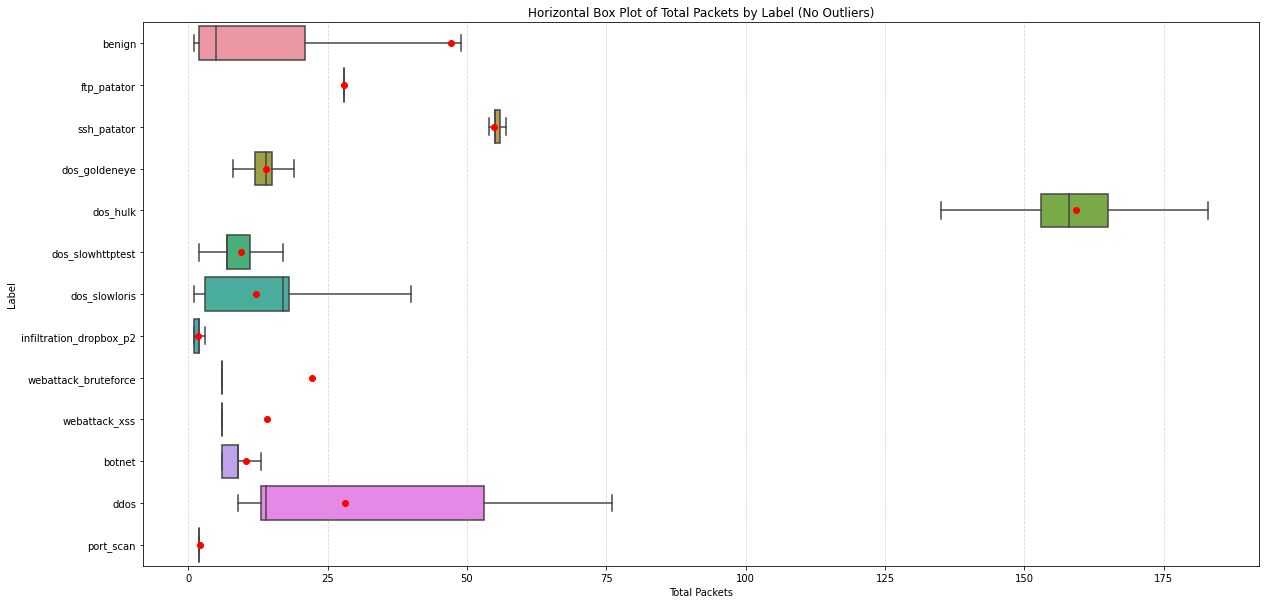

In [318]:
# col_analysis = ['dos_goldeneye', 'port_scan', 'botnet', 'ssh_patator', 'benign', 'dos_slowloris', 'ftp_patator', 'ddos', 'web attack',
#           'dos_slowhttptest', 'infiltration', 'dos_hulk']
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='total_packets', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Total Packets')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Total Packets by Label (No Outliers)')

plt.show()

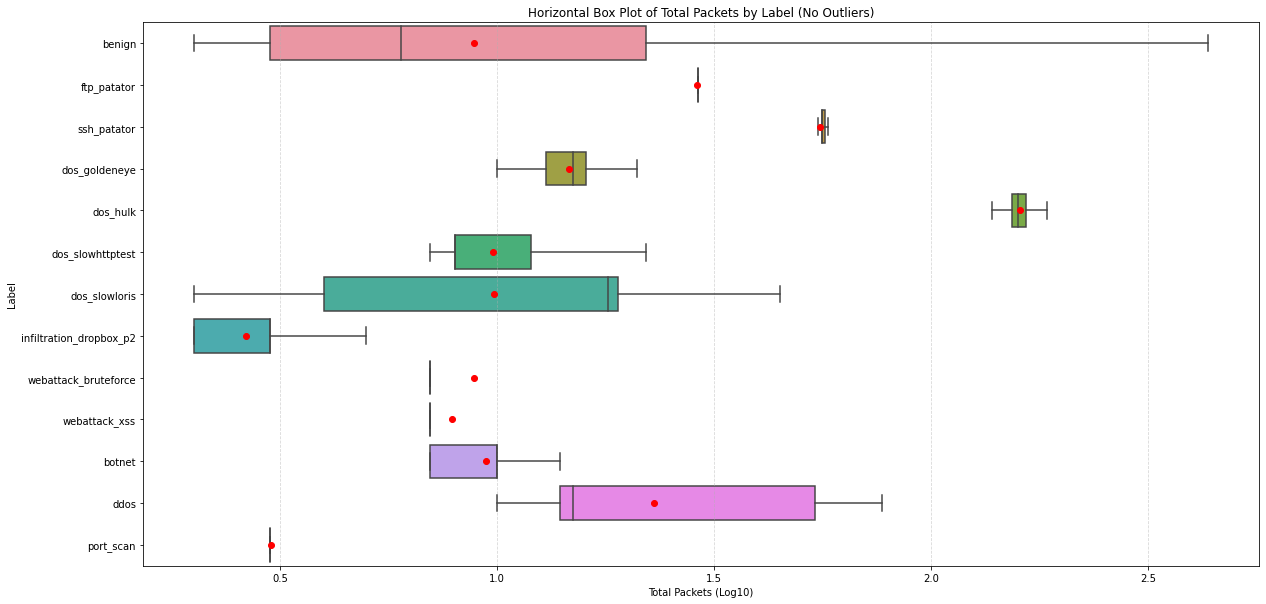

In [319]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='total_packets_log', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Total Packets (Log10)')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Total Packets by Label (No Outliers)')

plt.show()

Perform T-tests for all Pairs of Labels

In [320]:
labels = data['label'].unique()

In [321]:
grouped = data.groupby('label')['total_packets']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [322]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [323]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
0,benign,ftp_patator,0.187519,0.851253
1,benign,ssh_patator,-0.064295,0.948735
2,benign,dos_goldeneye,0.445360,0.656060
3,benign,dos_hulk,-2.054056,0.039971
4,benign,dos_slowhttptest,0.378528,0.705039
5,benign,dos_slowloris,0.336694,0.736348
6,benign,infiltration_dropbox_p2,1.762882,0.077921
7,benign,webattack_bruteforce,0.142583,0.886619
8,benign,webattack_xss,0.132640,0.894478
9,benign,botnet,0.198462,0.842683


=> **Conclusion**: 
- Benign Traffic vs. Attacks:

The distribution of 'total_packets' does not exhibit statistically significant differences between benign traffic and the aggregate of all attack types. This suggests that 'total_packets' alone may not reliably differentiate benign traffic from attacks.

=> Infiltration and Port-Scan are different !

- Differentiation Among Attack Types:

However, 'total_packets' demonstrates statistically significant differences among specific attack types, including DDoS, dos_goldeneye, dos_hulk, dos_slowhttptest, and dos_slowloris. Therefore, 'total_packets' serves as a useful feature for distinguishing between these specific types of attacks.

- `inter_arrival_mean`

In [324]:
data['inter_arrival_mean'].describe()

count    1.060019e+06
mean     9.720333e+01
std      5.817082e+02
min     -1.300000e-05
25%      1.680000e-04
50%      3.186100e-02
75%      1.030839e+00
max      9.537357e+03
Name: inter_arrival_mean, dtype: float64

In [325]:
# inter_arrival_mean must be null ONLT if the total packets is == 1 

assert data[data['inter_arrival_mean'].isnull() & data['total_packets'] > 1].shape[0] == 0

In [326]:
data['inter_arrival_mean_modified'] = data['inter_arrival_mean'].fillna(0)

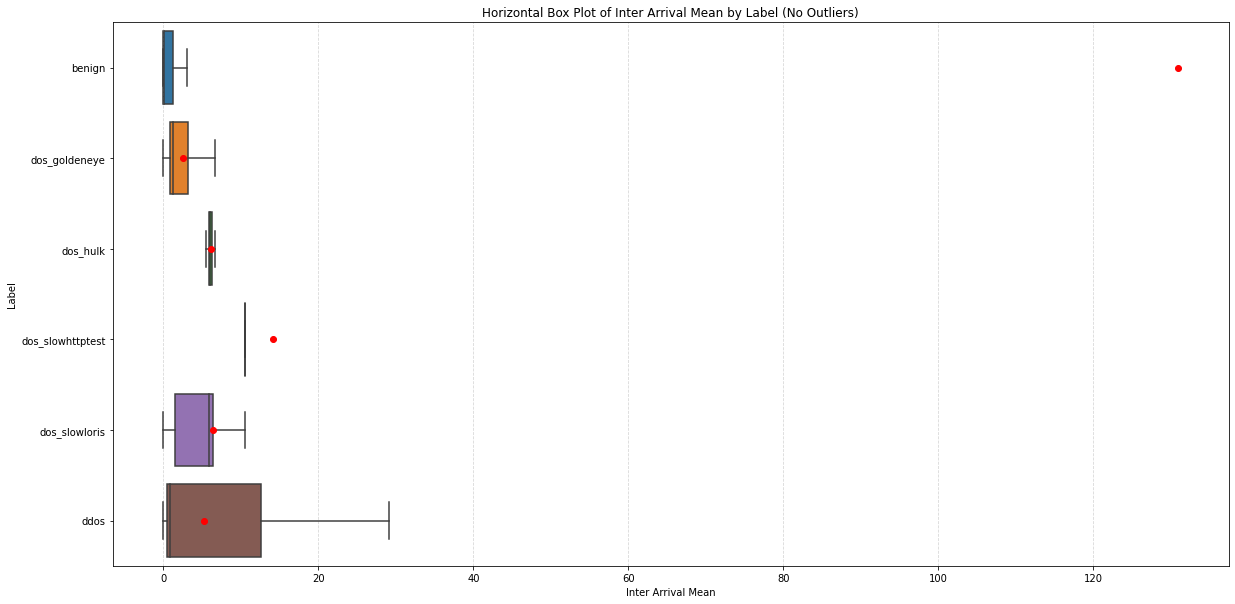

In [327]:
col_analysis_1 = ['benign', 'ddos','dos_slowloris','dos_slowhttptest', 'dos_hulk', 'dos_goldeneye']
# col_analysis = data['label'].unique()
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='inter_arrival_mean_modified', data=data[data['label'].isin(col_analysis_1)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Inter Arrival Mean')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Inter Arrival Mean by Label (No Outliers)')

plt.show()

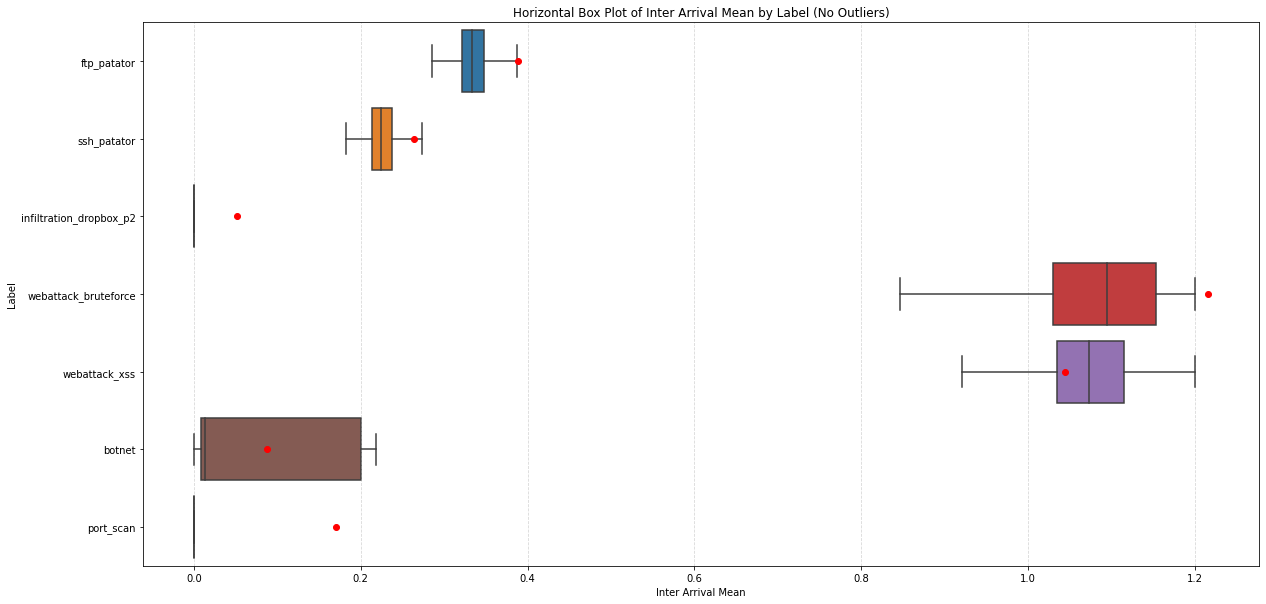

In [328]:
col_analysis_2 = set(data['label'].unique()) - set(col_analysis_1)#['web attack', 'ssh_patator', 'port_scan', 'heartbleed', 'ftp_patator', 'botnet']
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='inter_arrival_mean_modified', data=data[data['label'].isin(col_analysis_2)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Inter Arrival Mean')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Inter Arrival Mean by Label (No Outliers)')

plt.show()

Perform T-tests for all Pairs of Labels

In [329]:
labels = data['label'].unique()

In [330]:
grouped = data.groupby('label')['inter_arrival_mean_modified']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [331]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [332]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
22,ftp_patator,port_scan,2.159555,0.030809
32,ssh_patator,port_scan,0.802147,0.422469
43,dos_hulk,dos_slowloris,-3.121360,0.001803
65,infiltration_dropbox_p2,botnet,-0.962025,0.336041
68,webattack_bruteforce,webattack_xss,0.872552,0.383010
76,botnet,port_scan,-0.450693,0.652211


=> **Conclusion**: 


- Differentiation Between Attacks and Non-Attacks:

Inter-arrival time demonstrates statistically significant differences between attacks and non-attacks. This suggests that inter-arrival time is a valuable indicator for distinguishing malicious traffic from benign traffic.

=> Port Scan and Infiltration_drop_p2 have differetn distributions!

- Differentiation Among Attack Types:

Inter-arrival time also shows statistically significant differences among most attack types. However, the result is not statistically significant for the 'heartbleed' attack. This exception is disregarded due to the limited sample size (only 1 sample for 'heartbleed').


`total_fwd_packets` & `total_bwd_packets` 

In [333]:
assert data['total_fwd_packets'].isnull().sum() == 0

In [334]:
data['total_fwd_packets_log'] = np.log1p(data['total_fwd_packets'])
data['total_bwd_packets_log'] = np.log1p(data['total_bwd_packets'])

In [335]:
data[(data['label'] == 'infiltration_dropbox_p2') & (data['total_fwd_packets'] < data['total_bwd_packets'] )][['total_fwd_packets', 'total_bwd_packets']].shape[0]/data[(data['label'] == 'infiltration_dropbox_p2')].shape[0]

0.04401305725955246

In [336]:
data[(data['label'] == 'port_scan')][['total_bwd_packets', 'total_fwd_packets']].describe()

,total_bwd_packets,total_fwd_packets
count,160003.000000,160003.000000
mean,1.006462,1.019287
std,0.170976,0.339229
min,0.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,36.000000,98.000000


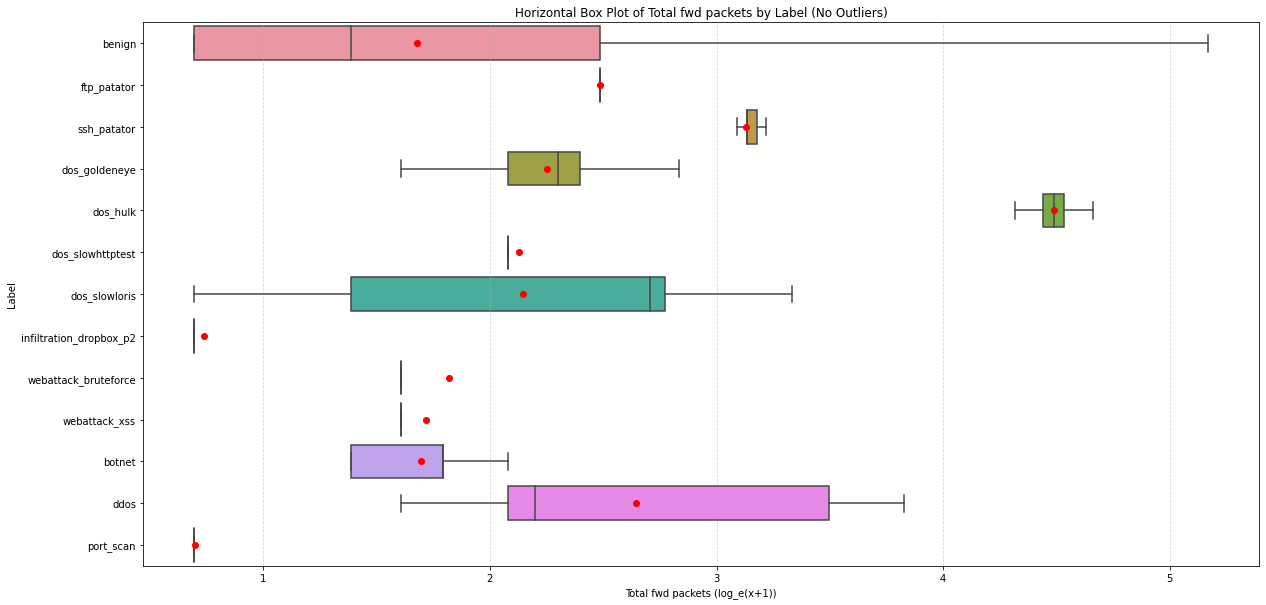

In [337]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='total_fwd_packets_log', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Total fwd packets (log_e(x+1))')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Total fwd packets by Label (No Outliers)')

plt.show()

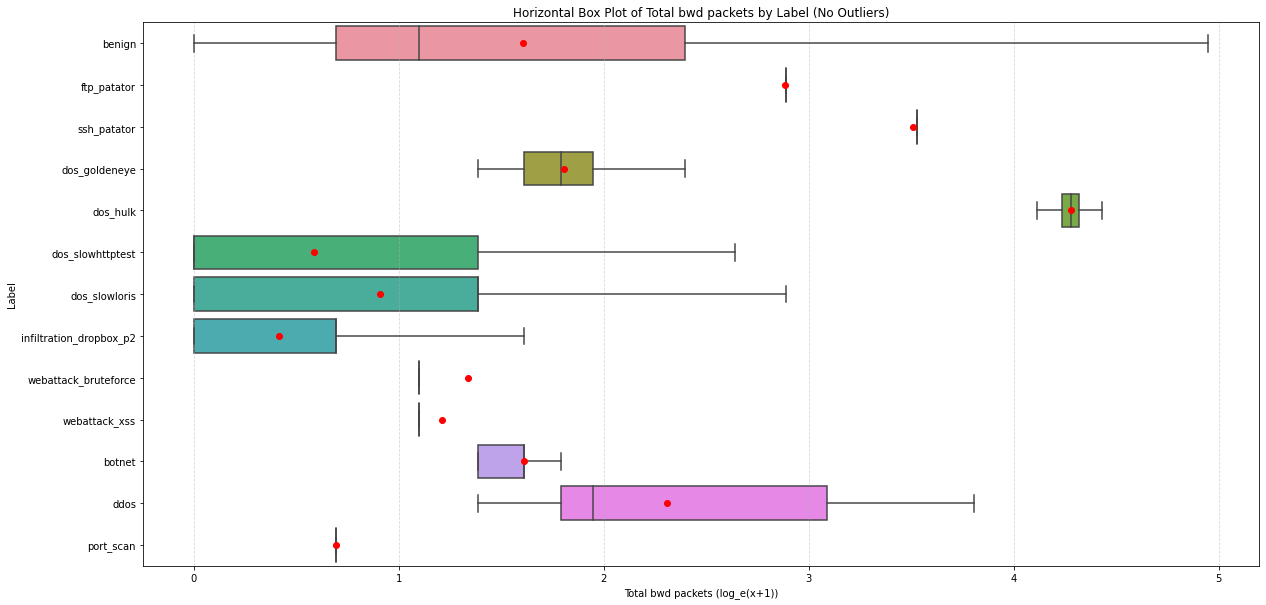

In [338]:
plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='total_bwd_packets_log', data=data, showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Total bwd packets (log_e(x+1))')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Total bwd packets by Label (No Outliers)')

plt.show()

Perform T-tests for all Pairs of Labels

In [339]:
labels = data['label'].unique()

In [340]:
grouped = data.groupby('label')['total_fwd_packets']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [341]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [342]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
0,benign,ftp_patator,0.234799,0.814365
1,benign,ssh_patator,-0.014368,0.988536
2,benign,dos_goldeneye,0.392617,0.694602
3,benign,dos_hulk,-2.860620,0.004228
4,benign,dos_slowhttptest,0.318033,0.750460
5,benign,dos_slowloris,0.264641,0.791286
6,benign,infiltration_dropbox_p2,1.832450,0.066885
7,benign,webattack_bruteforce,0.090105,0.928203
8,benign,webattack_xss,0.112309,0.910578
9,benign,botnet,0.204731,0.837782


In [343]:
grouped = data.groupby('label')['total_bwd_packets']
results = []
for label1, label2 in combinations(labels, 2):
    group1 = grouped.get_group(label1)
    group2 = grouped.get_group(label2)
    t_stat, p_value = ttest_ind(group1, group2)
    results.append((label1, label2, t_stat, p_value))
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Label 1', 'Label 2', 'T-statistic', 'P-value'])

In [344]:
# Example: Bonferroni correction
adjusted_alpha = 0.05 / len(results_df)  # Adjusted significance threshold

# Filter significant results based on adjusted alpha
significant_results = results_df[results_df['P-value'] < adjusted_alpha]
non_significant_results = results_df[results_df['P-value'] >= adjusted_alpha]

In [345]:
non_significant_results

,Label 1,Label 2,T-statistic,P-value
0,benign,ftp_patator,0.152124,0.879089
1,benign,ssh_patator,-0.101635,0.919046
2,benign,dos_goldeneye,0.484752,0.627853
3,benign,dos_hulk,-1.450390,0.146950
4,benign,dos_slowhttptest,0.423728,0.671764
5,benign,dos_slowloris,0.390547,0.696132
6,benign,infiltration_dropbox_p2,1.710588,0.087158
7,benign,webattack_bruteforce,0.181820,0.855724
8,benign,webattack_xss,0.147830,0.882477
9,benign,botnet,0.193745,0.846376


=> Conclusion:

Doesn't help in destinguishing between benign and attacks; 
For instance, It helps differentiate infiltration_dropbox_p2 and portscan; DDoS; it struggles to differentiate webattack_xss incidents.

**Analyzing: Flow Observation Duration**

In [346]:
data['first_timestamp_dt'] = pd.to_datetime(data['first_timestamp'])
data['last_timestamp_dt'] = pd.to_datetime(data['last_timestamp'])

In [347]:
data['diff_in_seconds'] = (data['last_timestamp_dt'] - data['first_timestamp_dt']).dt.total_seconds()

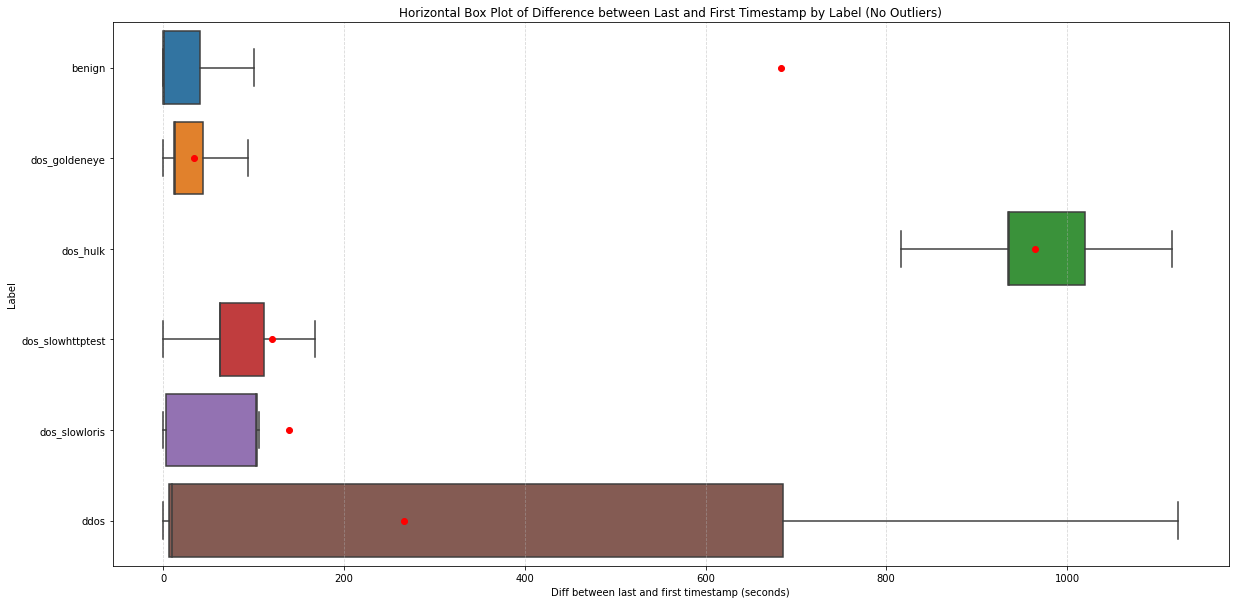

In [348]:
col_analysis_1 = ['benign', 'ddos','dos_slowloris','dos_slowhttptest', 'dos_hulk', 'dos_goldeneye']

plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='diff_in_seconds', data=data[data['label'].isin(col_analysis_1)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Diff between last and first timestamp (seconds)')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Difference between Last and First Timestamp by Label (No Outliers)')

plt.show()

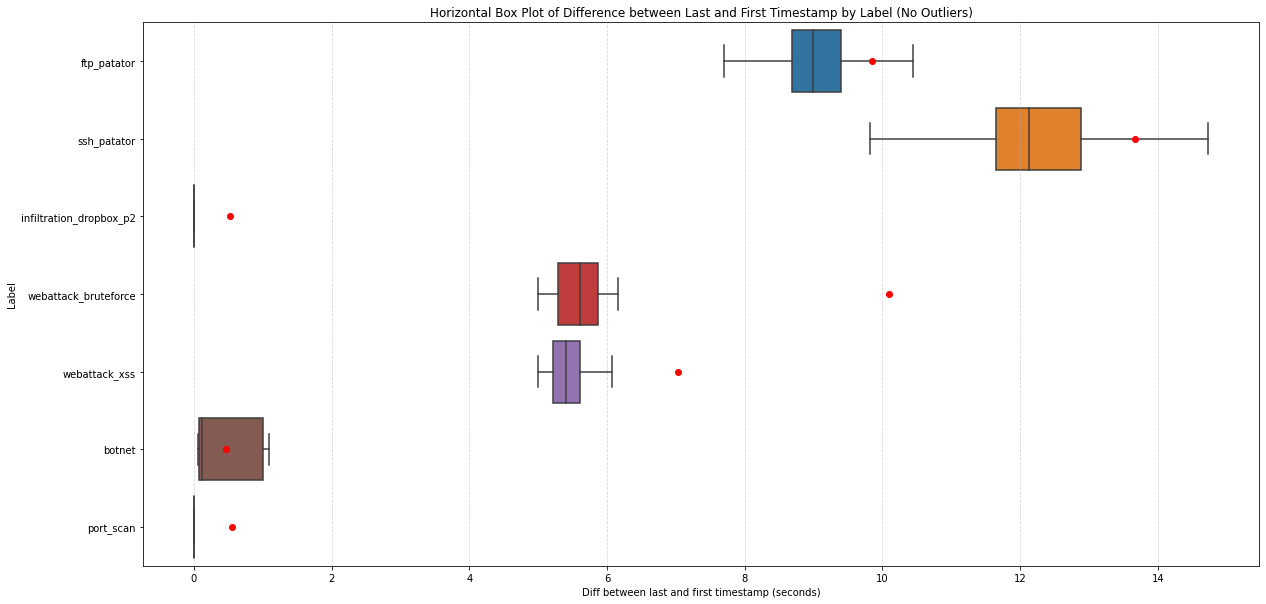

In [349]:
col_analysis_2 = set(data['label']) - set(col_analysis_1)

plt.figure(figsize=(20, 10))

# Use sns.boxplot with x as the category and y as the value
sns.boxplot(y='label', x='diff_in_seconds', data=data[data['label'].isin(col_analysis_2)], showfliers=False, showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'red'})

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.5)  # Add vertical gridlines with dashed style and transparency

# Add labels and title
plt.xlabel('Diff between last and first timestamp (seconds)')
plt.ylabel('Label')
plt.title('Horizontal Box Plot of Difference between Last and First Timestamp by Label (No Outliers)')

plt.show()

In [350]:
data['diff_in_seconds'].describe()

count    1.092506e+06
mean     5.148961e+02
std      2.608950e+03
min      0.000000e+00
25%      1.560000e-04
50%      8.968800e-02
75%      1.110656e+01
max      2.904384e+04
Name: diff_in_seconds, dtype: float64

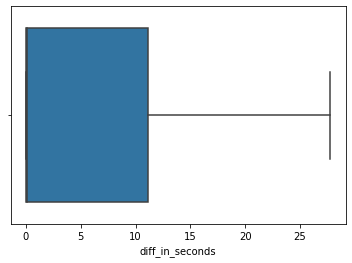

In [351]:
sns.boxplot(x=data['diff_in_seconds'],  showfliers=False);

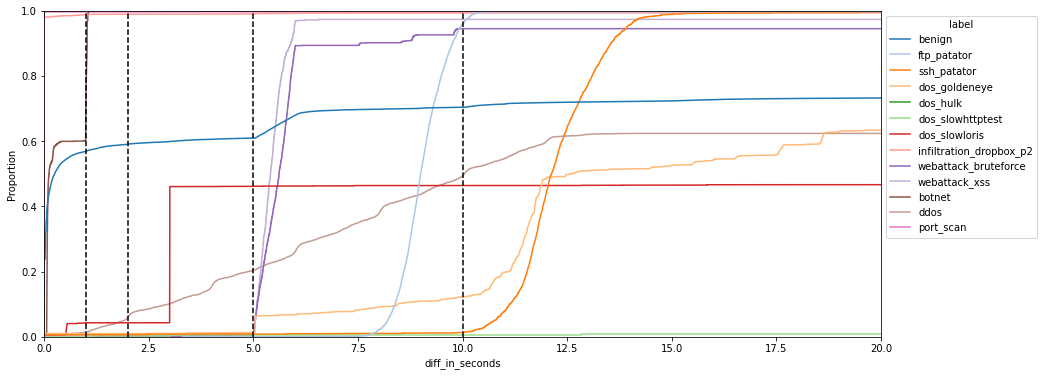

In [352]:
pair = sns.color_palette("tab20")

ax = sns.ecdfplot(data=data, x="diff_in_seconds", hue='label', palette=pair[:len(set(data['label']))])

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gcf().set_size_inches(15, 6)  # Set figure size (width, height)
plt.xlim(0, 20)  # Adjust the x-axis limits here

# Draw vertical lines at specific x-values (1, 2, 5, and 10)
obs_intervals = [1, 2, 5, 10]
for line_value in obs_intervals:
    plt.axvline(x=line_value, color='black', linestyle='--', linewidth=1.5)

plt.show()

In [353]:
obs_intervals = [1, 2, 5, 10]
unique_labels = set(data['label'])
for i in obs_intervals:
    print(f'===========Obs Interval: {i}===========')
    for label in unique_labels:
        tmp = data[data['label'] == label]
        pct = (tmp[tmp['diff_in_seconds'] < i]).shape[0]*100/tmp.shape[0]
        print(f'{label}: {pct:.2f}%')

===========Obs Interval: 1===========
dos_hulk: 0.00%
dos_slowhttptest: 0.21%
dos_slowloris: 4.31%
botnet: 71.45%
ddos: 1.48%
webattack_bruteforce: 0.00%
benign: 56.93%
ftp_patator: 0.00%
port_scan: 99.68%
infiltration_dropbox_p2: 98.85%
dos_goldeneye: 1.03%
webattack_xss: 0.29%
ssh_patator: 0.64%
===========Obs Interval: 2===========
dos_hulk: 0.00%
dos_slowhttptest: 0.24%
dos_slowloris: 4.31%
botnet: 100.00%
ddos: 6.00%
webattack_bruteforce: 0.15%
benign: 59.07%
ftp_patator: 0.00%
port_scan: 99.68%
infiltration_dropbox_p2: 98.93%
dos_goldeneye: 1.03%
webattack_xss: 0.29%
ssh_patator: 0.64%
===========Obs Interval: 5===========
dos_hulk: 0.00%
dos_slowhttptest: 0.57%
dos_slowloris: 46.16%
botnet: 100.00%
ddos: 20.36%
webattack_bruteforce: 0.59%
benign: 60.97%
ftp_patator: 0.03%
port_scan: 99.68%
infiltration_dropbox_p2: 98.97%
dos_goldeneye: 1.31%
webattack_xss: 1.18%
ssh_patator: 0.84%
===========Obs Interval: 10===========
dos_hulk: 0.00%
dos_slowhttptest: 0.69%
dos_slowloris: 46.39

In [354]:
obs_intervals = [1, 2, 5, 10]
unique_labels = set(data['label'])
for i in obs_intervals:
    print(f'===========Obs Interval: {i}===========')
    for label in unique_labels:
        tmp = data[data['label'] == label]
        pct = (tmp[tmp['diff_in_seconds'] < i]).shape[0]*100/tmp.shape[0]
        print(f'{label}: {pct:.2f}%')

===========Obs Interval: 1===========
dos_hulk: 0.00%
dos_slowhttptest: 0.21%
dos_slowloris: 4.31%
botnet: 71.45%
ddos: 1.48%
webattack_bruteforce: 0.00%
benign: 56.93%
ftp_patator: 0.00%
port_scan: 99.68%
infiltration_dropbox_p2: 98.85%
dos_goldeneye: 1.03%
webattack_xss: 0.29%
ssh_patator: 0.64%
===========Obs Interval: 2===========
dos_hulk: 0.00%
dos_slowhttptest: 0.24%
dos_slowloris: 4.31%
botnet: 100.00%
ddos: 6.00%
webattack_bruteforce: 0.15%
benign: 59.07%
ftp_patator: 0.00%
port_scan: 99.68%
infiltration_dropbox_p2: 98.93%
dos_goldeneye: 1.03%
webattack_xss: 0.29%
ssh_patator: 0.64%
===========Obs Interval: 5===========
dos_hulk: 0.00%
dos_slowhttptest: 0.57%
dos_slowloris: 46.16%
botnet: 100.00%
ddos: 20.36%
webattack_bruteforce: 0.59%
benign: 60.97%
ftp_patator: 0.03%
port_scan: 99.68%
infiltration_dropbox_p2: 98.97%
dos_goldeneye: 1.31%
webattack_xss: 1.18%
ssh_patator: 0.84%
===========Obs Interval: 10===========
dos_hulk: 0.00%
dos_slowhttptest: 0.69%
dos_slowloris: 46.39

# Model

In [355]:
features = ['flow_duration', 'inter_arrival_mean_modified', 'total_packets', 'total_fwd_packets', 'total_bwd_packets']
label = ['label']

In [356]:
X = data[features]
y = data[label]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [357]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [358]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=10,
    max_depth=3,
    objective='multi:softmax')

In [359]:
# Train the classifier
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [362]:
le_name_mapping

{'benign': 0,
 'botnet': 1,
 'ddos': 2,
 'dos_goldeneye': 3,
 'dos_hulk': 4,
 'dos_slowhttptest': 5,
 'dos_slowloris': 6,
 'ftp_patator': 7,
 'infiltration_dropbox_p2': 8,
 'port_scan': 9,
 'ssh_patator': 10,
 'webattack_bruteforce': 11,
 'webattack_xss': 12}

In [361]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    234858
           1       0.00      0.00      0.00       385
           2       0.87      0.76      0.81     13665
           3       0.85      0.14      0.25      2241
           4       1.00      1.00      1.00      4279
           5       0.93      0.71      0.80      1231
           6       0.98      0.84      0.90      1176
           7       1.00      0.99      0.99      1233
           8       0.91      0.56      0.69     19089
           9       0.85      0.98      0.91     48103
          10       0.98      0.94      0.96       888
          11       1.00      0.04      0.09       402
          12       1.00      0.02      0.05       202

    accuracy                           0.94    327752
   macro avg       0.87      0.61      0.65    327752
weighted avg       0.94      0.94      0.94    327752



/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [366]:
scores = cross_val_score(xgb_clf, X_test, y_test, cv=5, scoring='f1_macro')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.65 accuracy with a standard deviation of 0.01


## SHAP Analysis

In [419]:
data_filtered = data[data['label'].isin(['infiltration_dropbox_p2', 'port_scan'])].copy()
X = data_filtered[features]
y = data_filtered[label]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

/Users/danieldacosta/miniconda3/envs/work/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [421]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [424]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=10,
    max_depth=3)
    # objective='multi:softmax')

In [425]:
# Train the classifier
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [426]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.57      0.73     18842
           1       0.86      1.00      0.92     48183

    accuracy                           0.88     67025
   macro avg       0.92      0.79      0.82     67025
weighted avg       0.89      0.88      0.87     67025



In [439]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)
shap_obj = explainer(shap_values)

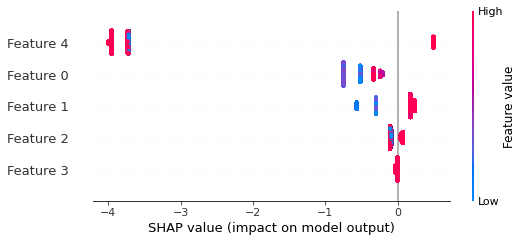

In [440]:
shap.plots.beeswarm(shap_obj)

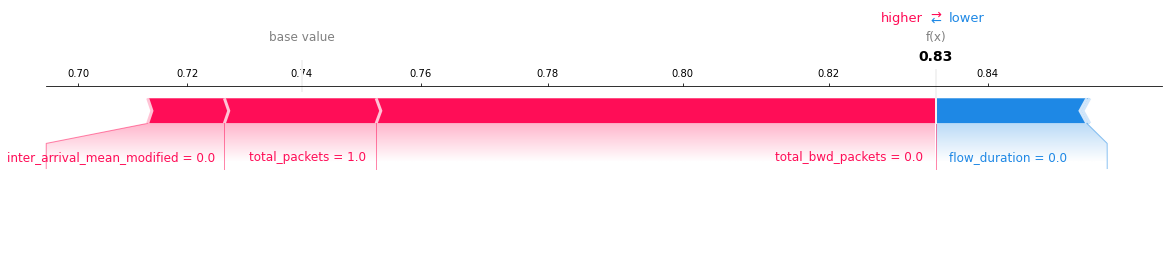

In [443]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0],
    link="logit",
    matplotlib=True,
)

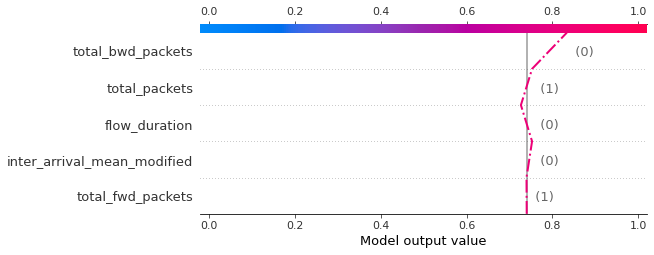

In [445]:
shap.decision_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0],
    link="logit",
    highlight=0
)

 # STOP HERE FOR NOW

In [ ]:
data['total_packets'] = data['total_bwd_packets'] + data['total_fwd_packets']

In [ ]:
plt.figure(figsize=(30, 6))
sns.boxplot(x='label', y='total_packets', data=data, showfliers=False)
plt.title('Box Plot of flow_duration by label')
plt.xlabel('Label')
plt.ylabel('total_packets')
plt.show()

Box plots analysis

In [ ]:
plt.figure(figsize=(30, 6))
sns.boxplot(x='label', y='flow_duration', data=df, showfliers=False)
plt.title('Box Plot of flow_duration by label')
plt.xlabel('Label')
plt.ylabel('fin_flag_count')
plt.show()

In [ ]:
plt.figure(figsize=(30, 6))
sns.boxplot(x='label', y='total_size', data=df, showfliers=False)
plt.title('Box Plot of total_size by label')
plt.xlabel('Label')
plt.ylabel('rst_flag_count')
plt.show()

- Handling NaNs

In [ ]:
df.isnull().sum()*100/df.shape[0]

In [ ]:
df_benign = df[df['label'] == 'benign'].copy()
df_benign.isnull().sum()*100/df_benign.shape[0]

In [ ]:
# # Get only the numeric columns
# numeric_cols = df.select_dtypes(include=['number'])

# # Fill NaN values with the mean of each numeric column
# df[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())

- Convert datetime features -> get the Unix timestamp.

In [ ]:
df['first_timestamp'].value_counts()

In [ ]:
# df['first_timestamp'] = pd.to_datetime(df['first_timestamp']).astype(int) / 10**9
# df['first_timestamp_fwd'] = pd.to_datetime(df['first_timestamp_fwd']).astype(int) / 10**9


# df['last_timestamp_bwd'] = pd.to_datetime(df['last_timestamp_bwd']).astype(int) / 10**9

# df['last_timestamp'] = pd.to_datetime(df['last_timestamp']).astype(int) / 10**9

# df['first_timestamp_bwd'] = pd.to_datetime(df['first_timestamp_bwd']).astype(int) / 10**9

# df['last_timestamp_fwd'] = pd.to_datetime(df['last_timestamp_fwd']).astype(int) / 10**9


# Dataframe - Rescaled Proportions

In [ ]:
original_total = 2187304

In [ ]:
benign = 1807787
ddos = 320269
portscan = 57305
botnet = 1943

In [ ]:
print('Benign %: ', benign/original_total)
print('Ddos %: ', ddos/original_total)
print('PortScan %: ', portscan/original_total)
print('Botnet %: ', botnet/original_total)

In [ ]:
benign_count = df['label'].value_counts().benign
ddos_count = int(np.floor(df['label'].value_counts().benign*ddos/original_total))
portscan_count = int(np.floor(df['label'].value_counts().benign*portscan/original_total))
botnet_count = int(np.floor(df['label'].value_counts().benign*botnet/original_total))

In [ ]:
df_resampled = pd.concat([
    df[df['label'] == 'benign'],
    df[df['label'] == 'ddos'].sample(ddos_count, random_state=42),
    df[df['label'] == 'port_scan'].sample(portscan_count, random_state=42),
    df[df['label'] == 'botnet'].sample(botnet_count, random_state=42)
])

In [ ]:
print(df_resampled['label'].value_counts())
# Compute proportions
proportions = df_resampled['label'].value_counts()*100 / len(df_resampled)

# Display proportions
print(proportions)

# Split dataset

In [ ]:
# df = df_resampled

In [ ]:
df.head()

In [ ]:
# Removing non-numerical features
features = list(set(df.columns) -\
    set(['label', 'flow_id', 'src_ip', 'dst_port', 'dst_ip', 'sport', 'pkt_lens', 'fwd_inter_arrival_times', 'fwd_arrival_times',
         'bwd_arrival_times', 'arrival_times', 'bwd_pkt_lens', 'inter_arrival_times', 'fwd_pkt_lens', 'bwd_inter_arrival_times']) -\
              set(['first_timestamp', 'last_timestamp', 'first_timestamp_fwd', 'last_timestamp_fwd', 'first_timestamp_bwd', 'last_timestamp_bwd']))
label = ['label']

In [ ]:
features

# Split dataset

In [ ]:
# # COLUMN len_per_sec has INF

# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df['len_per_sec'].fillna(df['len_per_sec'].mean(), inplace=True)

In [ ]:
X.isnull().sum()

In [ ]:


# X = df[features]
# # X = df[['fin_flag_count', 'rst_flag_count']]
# y = df['label']

# Droping NaN
X = df[ features+ ['label']].dropna(how='any')
y = X[label]
X = X[features]



label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Binarize the labels
y_bin = label_binarize(y_encoded, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
X.shape[0]

# Model

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from itertools import cycle

- Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

In [ ]:
# Create the classifier
clf = OneVsRestClassifier(Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter=10000))]))

In [ ]:
# Train the classifier
clf.fit(X_train, y_train)

In [ ]:
y_score = clf.predict_proba(X_test)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

- XGB

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [ ]:
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
# Initialize XGBoost classifier for multiclass classification
xgb_clf = XGBClassifier(
    n_estimators=10,
    max_depth=3,
    objective='multi:softmax')#, num_class=len(set(y_train)))

In [ ]:
set(y_train)

In [ ]:
# Train the classifier
xgb_clf.fit(X_train, y_train)

In [ ]:
xgb_clf.classes_

In [ ]:
# Predict on the test set
y_pred = xgb_clf.predict(X_test)
y_pred_prob = xgb_clf.predict_proba(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Plot feature importance
xgb.plot_importance(xgb_clf)
plt.show()

In [ ]:
scores = cross_val_score(xgb_clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
# Get unique elements and their counts
unique_elements, counts = np.unique(y_test, return_counts=True)

# Zip them together for readability
element_counts = dict(zip(unique_elements, counts))

# Print the counts
print("Element Counts:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

In [ ]:
# Get unique elements and their counts
unique_elements, counts = np.unique(y_pred, return_counts=True)

# Zip them together for readability
element_counts = dict(zip(unique_elements, counts))

# Print the counts
print("Element Counts:")
for element, count in element_counts.items():
    print(f"{element}: {count}")

In [ ]:
# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

- RF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

In [ ]:
feature_names = list(X_train.columns)

In [ ]:
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

In [ ]:
# Initialize Random Forest classifier for multiclass classification
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

y_pred_prob = rf_clf.predict_proba(X_test)

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)  # Replace with original feature names and rotate x-axis labels by 45 degrees
plt.xlim([-1, X.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
scores = cross_val_score(rf_clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))